Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST_200k.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
import pdb

image_size = 28
num_labels = 10

def reformat(dataset, labels):
  #pdb.set_trace()
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [24]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000. # Run all 200k training data

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :]) #train_dataset[:train_subset, :]
  tf_train_labels = tf.constant(train_labels[:train_subset, :])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random valued following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Let's run this computation and iterate:

In [25]:
num_steps = 3001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  lossVec = []
  trainAcc = []
  validAcc = []
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    lossVec.append(l)
    trainAcc.append(accuracy(predictions, train_labels[:train_subset, :]))
    validAcc.append(accuracy(valid_prediction.eval(), valid_labels))
    """
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    """
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Test accuracy: 83.5%


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [27]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(lossVec)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

plt.clf()
plt.plot(trainAcc, label= "Training Accuracy")
plt.plot(validAcc, label= "Valid Accuracy")
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.show()



Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [28]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [29]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  lossVec = []
  trainAcc = []
  validAcc = []
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    """
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    """
    lossVec.append(l)
    trainAcc.append(accuracy(predictions, batch_labels))
    validAcc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Test accuracy: 86.8%


In [31]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(lossVec)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

plt.clf()
plt.plot(trainAcc, label= "Minibatch Accuracy")
plt.plot(validAcc, label= "Valid Accuracy")
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.show()


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [4]:
batch_size = 128
hidden_layer_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weightsHidden = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biasesHidden = tf.Variable(tf.zeros([hidden_layer_size]))

  weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
    
  logitsHidden = tf.matmul(tf_train_dataset, weightsHidden) + biasesHidden
  hiddenLayer = tf.nn.relu(logitsHidden)

  # Training computation.
  logits = tf.matmul(hiddenLayer, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
 
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weightsHidden) + biasesHidden)
  valid_logits = tf.matmul(valid_hidden, weights) + biases
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weightsHidden) + biasesHidden)
  test_logits = tf.matmul(test_hidden, weights) + biases
  test_prediction = tf.nn.softmax(test_logits)

In [6]:
num_steps = 30001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  lossVec = []
  trainAcc = []
  validAcc = []
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    lossVec.append(l)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      
      trainAcc.append(accuracy(predictions, batch_labels))
      validAcc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 294.453857
Minibatch loss at step 100: 25.903187
Minibatch loss at step 200: 49.014881
Minibatch loss at step 300: 20.449303
Minibatch loss at step 400: 32.304825
Minibatch loss at step 500: 19.614372
Minibatch loss at step 600: 12.178806
Minibatch loss at step 700: 31.139439
Minibatch loss at step 800: 6.888573
Minibatch loss at step 900: 8.415754
Minibatch loss at step 1000: 11.650371
Minibatch loss at step 1100: 18.979389
Minibatch loss at step 1200: 16.012829
Minibatch loss at step 1300: 7.588346
Minibatch loss at step 1400: 7.024184
Minibatch loss at step 1500: 7.070252
Minibatch loss at step 1600: 4.128470
Minibatch loss at step 1700: 1.147847
Minibatch loss at step 1800: 2.568570
Minibatch loss at step 1900: 6.358519
Minibatch loss at step 2000: 2.701953
Minibatch loss at step 2100: 2.706118
Minibatch loss at step 2200: 4.188989
Minibatch loss at step 2300: 7.529970
Minibatch loss at step 2400: 3.524499
Minibatch loss at step 2500: 2.975404


Save train and valid accuracy 

In [9]:
fName = 'Experiment_1.pickle'

try:
  f = open(fName, 'wb')
  save = {
    'lossVec': lossVec,
    'trainAcc': trainAcc,
    'validAcc': validAcc,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [10]:
pickle_file = 'Experiment_1.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  lossVec = save['lossVec']
  trainAcc = save['trainAcc']
  validAcc = save['validAcc']
  del save  # hint to help gc free up memory

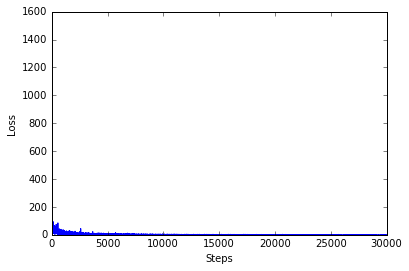

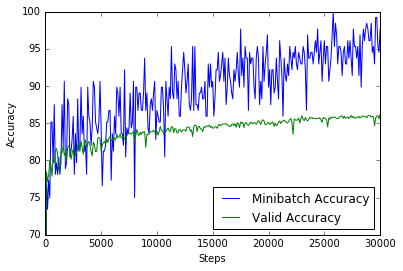

In [13]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

plt.clf()
plt.plot(lossVec)
plt.xlabel('Steps')
plt.ylabel('Loss')
axes = plt.gca()
axes.set_ylim([0,200])
plt.show()

plt.clf()
plt.plot(xrange(0,30001,100),trainAcc, label= "Minibatch Accuracy")
plt.plot(xrange(0,30001,100),validAcc, label= "Valid Accuracy")
axes = plt.gca()
axes.set_ylim([70,100])
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.show()



# Results

Test accuracy with a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes is: 89.2%